In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import catboost as cb
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import warnings

In [2]:
#Define random seed for result reproduction
random_seed = 30
np.random.seed(random_seed)

In [3]:
# Load the pickle file
pickle_path = "../data/processed/final_data.pck"

with open(pickle_path, 'rb') as f:
    data = pickle.load(f)
    
warnings.filterwarnings('ignore')
df = data
target = 'price'
df = df.drop(columns=['host_id'])

In [4]:
# separate features and target variable
X = df.drop(target, axis=1)
y = df[target]

# remove columns with any missing values
X = X.dropna(axis=1, how='any')

# one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

Linear regression

In [5]:
# Modeling
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_lr = r2_score(y_test, y_pred)

print("Linear regression results")
print(f"RMSE: {rmse_lr}")
print(f"R^2: {r2_lr}")

Linear regression results
RMSE: 38060.542803867516
R^2: 0.0181137455430449


Random forest

In [6]:
# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=random_seed)
rf.fit(X_train, y_train)

# predictions for the test set
y_pred_rf = rf.predict(X_test)

# calculating r2 for random forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest results")
print(f"RMSE: {rmse_rf}")
print(f"R^2: {r2_rf}")

Random Forest results
RMSE: 29479.547758167064
R^2: 0.4109490531105394


In [7]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

Random forest - Feature Importance

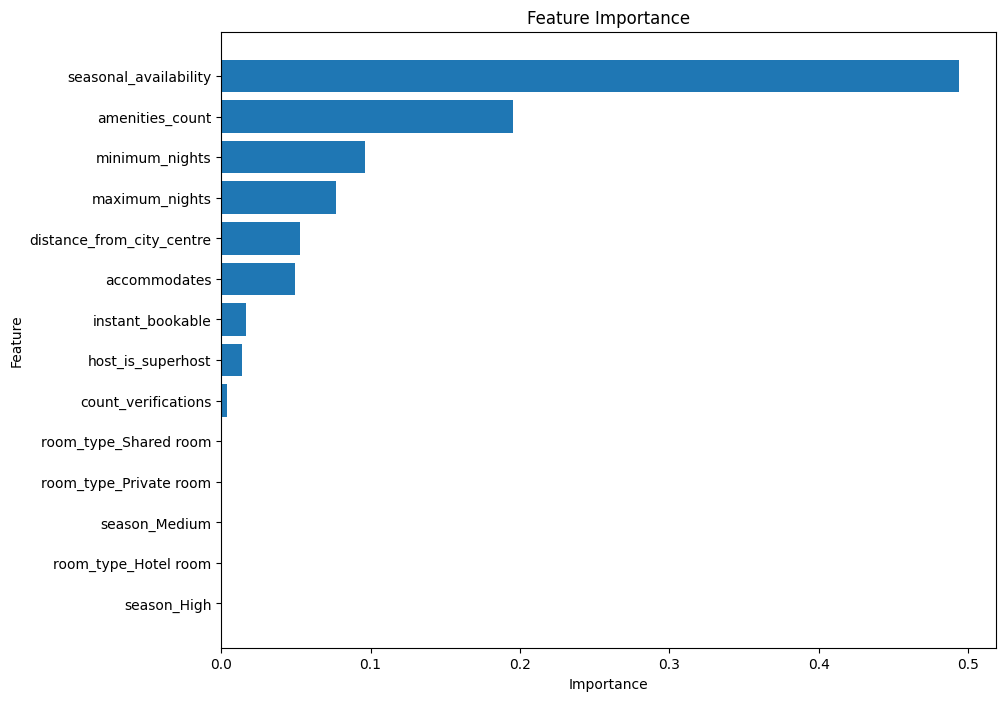

,Feature,Importance
7,seasonal_availability,0.494229
5,amenities_count,0.195282
2,minimum_nights,0.096482
3,maximum_nights,0.076982
8,distance_from_city_centre,0.052847
1,accommodates,0.049335
4,instant_bookable,0.016566
0,host_is_superhost,0.013766
6,count_verifications,0.003762
11,room_type_Shared room,0.000239


In [8]:
# Feature importance
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

feature_importances.head(10)

Optimized Random forest

In [9]:
# RandomForestRegressor
orf_regressor = RandomForestRegressor(random_state=random_seed, n_jobs=-1)


param_grid_orf = {
    'n_estimators': [100, 200, 300, 500],
    'max_features': [2,4,6],
    'min_samples_split': [1,2,4],
    'bootstrap': [True, False]
}

# GridSearchCV
grid_search_orf = GridSearchCV(estimator=orf_regressor, param_grid=param_grid_orf, scoring='r2', cv=5, verbose=1, n_jobs=-1)

# Training model
grid_search_orf.fit(X_train, y_train)

# Best parametres
best_params_orf = grid_search_orf.best_params_
print(f"Best params: {best_params_orf}")

# Best model
best_model_orf = grid_search_orf.best_estimator_

# Prediction with best model
predictions_orf = best_model_orf.predict(X_test)

# Model evaluation
rmse_orf = np.sqrt(mean_squared_error(y_test, predictions_orf))
r2_orf = r2_score(y_test, predictions_orf)

print("Optimized Random Forest results")
print(f"RMSE: {rmse_orf}")
print(f"R^2: {r2_orf}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'bootstrap': True, 'max_features': 2, 'min_samples_split': 4, 'n_estimators': 300}
Optimized Random Forest results
RMSE: 27099.87485855727
R^2: 0.5022104266506106


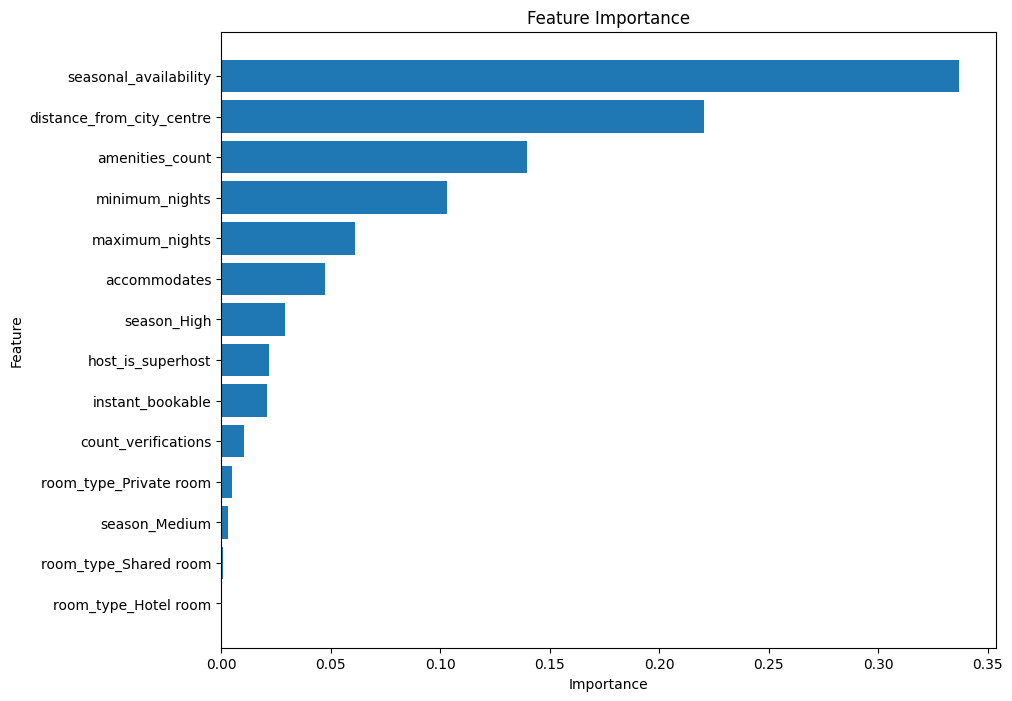

,Feature,Importance
7,seasonal_availability,0.337079
8,distance_from_city_centre,0.220642
5,amenities_count,0.139620
2,minimum_nights,0.102861
3,maximum_nights,0.061176
1,accommodates,0.047501
13,season_High,0.029302
0,host_is_superhost,0.021953
4,instant_bookable,0.020936
6,count_verifications,0.010241


In [10]:
# Feature importance
importances = best_model_orf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

feature_importances.head(10)

Optimized XGBoost

In [11]:
# Custom XGBoost wrapper to include early stopping
class XGBRegressorEarlyStopping(xgb.XGBRegressor):
    def __init__(self, early_stopping_rounds=10, **kwargs):
        super().__init__(**kwargs)
        self.early_stopping_rounds = early_stopping_rounds

    def fit(self, X, y, eval_set=None, **kwargs):
        if eval_set is None:
            eval_set = [(X, y)]
        return super().fit(X, y, eval_set=eval_set, **kwargs)

# Pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressorEarlyStopping(objective='reg:squarederror', random_state=random_seed, early_stopping_rounds=10))
])

# Parameter distribution for randomized search
param_dist = {
    'xgb__n_estimators': randint(50, 200),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__max_depth': randint(3, 10),
    'xgb__min_child_weight': randint(1, 6),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__gamma': uniform(0, 0.4),
    'xgb__reg_alpha': uniform(0, 1),
    'xgb__reg_lambda': uniform(0.5, 2)
}

# Randomized search
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, 
                                   cv=3, n_jobs=-1, verbose=2, scoring='r2', random_state=random_seed)
random_search.fit(X_train, y_train)

# Best model
best_pipeline = random_search.best_estimator_

# Predictions and evaluation
y_pred_xgb = best_pipeline.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("Best R2: {:.2f}".format(r2_xgb))
print("Best RMSE: {:.2f}".format(rmse_xgb))
print("Best Parameters: ", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:40715.34702
[1]	validation_0-rmse:40645.43190
[2]	validation_0-rmse:40582.85966
[3]	validation_0-rmse:40439.93250
[4]	validation_0-rmse:40361.88948
[5]	validation_0-rmse:40347.12910
[6]	validation_0-rmse:40266.68977
[7]	validation_0-rmse:40172.99995
[8]	validation_0-rmse:40115.31874
[9]	validation_0-rmse:39968.45302
[10]	validation_0-rmse:39858.17912
[11]	validation_0-rmse:39782.66536
[12]	validation_0-rmse:39568.78597
[13]	validation_0-rmse:39367.91211
[14]	validation_0-rmse:39308.93321
[15]	validation_0-rmse:39245.57439
[16]	validation_0-rmse:39144.97975
[17]	validation_0-rmse:39060.46666
[18]	validation_0-rmse:38987.71734
[19]	validation_0-rmse:38927.16010
[20]	validation_0-rmse:38856.73473
[21]	validation_0-rmse:38849.13190
[22]	validation_0-rmse:38807.90213
[23]	validation_0-rmse:38657.09935
[24]	validation_0-rmse:38600.49144
[25]	validation_0-rmse:38512.00991
[26]	validation_0-rmse:38381.31834
[27

Catboost

In [12]:
# CatBoostRegressor
cb_regressor = cb.CatBoostRegressor(random_seed=random_seed, silent=True)

# RandomizedSearch parameters
param_distributions_cb = {
    'iterations': [500, 1000, 1500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0]
}

# RandomizedSearchCV
random_search_cb = RandomizedSearchCV(
    estimator=cb_regressor,
    param_distributions=param_distributions_cb,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=random_seed
)

random_search_cb.fit(X_train, y_train)

# Best params
best_params_cb = random_search_cb.best_params_
print(f"Best params: {best_params_cb}")

# Best model
best_model_cb = random_search_cb.best_estimator_

# Prediction
predictions_cb = best_model_cb.predict(X_test)

# Model evaluation
rmse_cb = np.sqrt(mean_squared_error(y_test, predictions_cb))
r2_cb = r2_score(y_test, predictions_cb)

print("CatBoost results")
print(f"RMSE: {rmse_cb}")
print(f"R^2: {r2_cb}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'subsample': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 10, 'colsample_bylevel': 0.8, 'bootstrap_type': 'MVS'}
CatBoost results
RMSE: 30606.766587830316
R^2: 0.36504034991437984


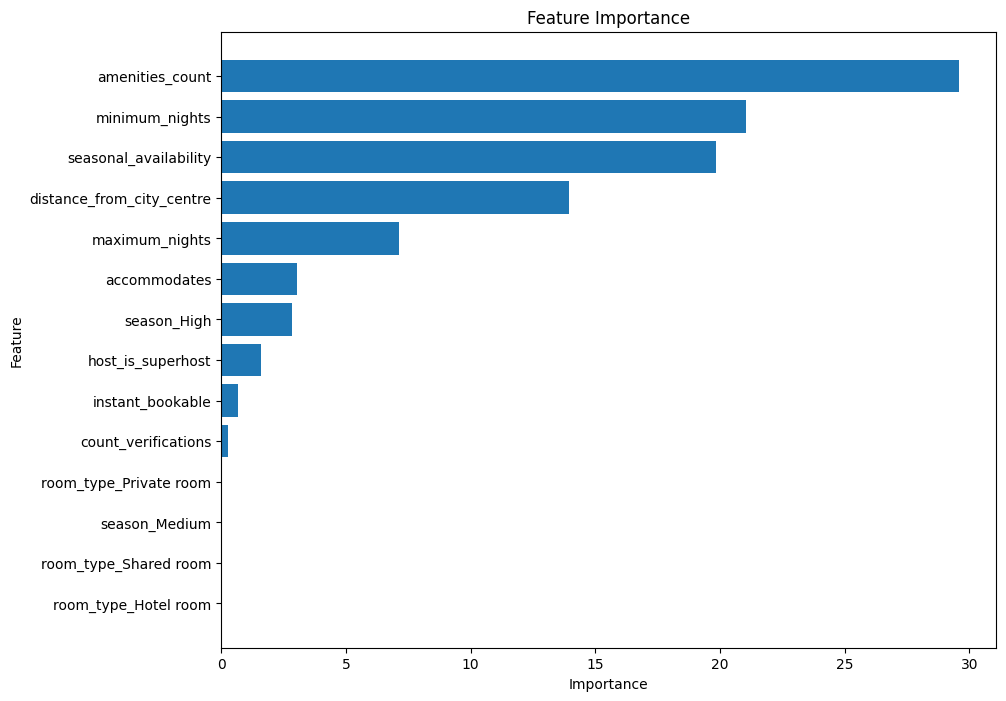

,Feature,Importance
5,amenities_count,29.602689
2,minimum_nights,21.025594
7,seasonal_availability,19.855410
8,distance_from_city_centre,13.932087
3,maximum_nights,7.128337
1,accommodates,3.029332
13,season_High,2.828128
0,host_is_superhost,1.585620
4,instant_bookable,0.672936
6,count_verifications,0.274580


In [13]:
# Feature importance
importances = best_model_cb.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

feature_importances.head(10)

In [14]:
# Model comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', "Optimized Random Forest", 'CatBoost', "Optimized XGBoost"],
    'RMSE': [rmse_lr, rmse_rf, rmse_orf, rmse_cb , rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_orf , r2_cb, r2_xgb]
})

print(results)

                     Model          RMSE        R²
0        Linear Regression  38060.542804  0.018114
1            Random Forest  29479.547758  0.410949
2  Optimized Random Forest  27099.874859  0.502210
3                 CatBoost  30606.766588  0.365040
4        Optimized XGBoost  33680.174920  0.231118


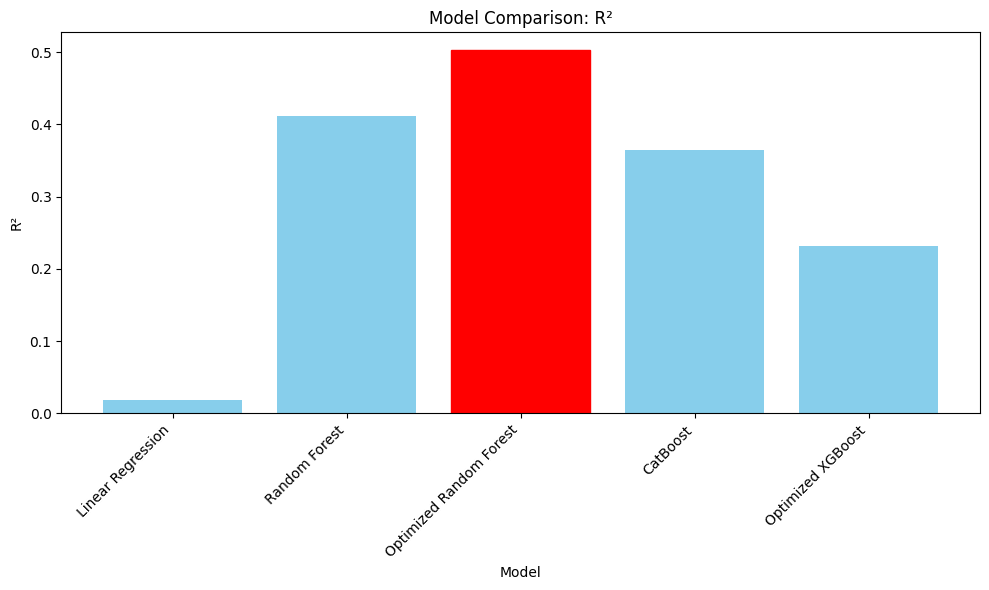

In [15]:
# Determine the best R²
best_r2_index = results['R²'].idxmax()


# R²
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['R²'], color='skyblue')
bars[best_r2_index].set_color('red')
plt.title('Model Comparison: R²')
plt.xlabel('Model')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Feature ranking and correlation with the target variable:
1. Feature 5 (amenities_count): Importance - 29.602688644026014, Correlation - 0.012310939299257842
2. Feature 2 (minimum_nights): Importance - 21.025593856699857, Correlation - 0.0007746051317098823
3. Feature 7 (seasonal_availability): Importance - 19.855410355146336, Correlation - 0.05606952509754852
4. Feature 8 (distance_from_city_centre): Importance - 13.932087396581162, Correlation - -0.013705263125297988
5. Feature 3 (maximum_nights): Importance - 7.128337380807861, Correlation - 0.03553176166019903
6. Feature 1 (accommodates): Importance - 3.029331899822013, Correlation - 0.033859513840003616
7. Feature 13 (season_High): Importance - 2.8281282258470215, Correlation - 0.056490747651585765
8. Feature 0 (host_is_superhost): Importance - 1.58562026534308, Correlation - -0.013726457162780923
9. Feature 4 (instant_bookable): Importance - 0.6729355404935823, Correlation - -0.010728844811371882
10. Feature 6 (count_verification

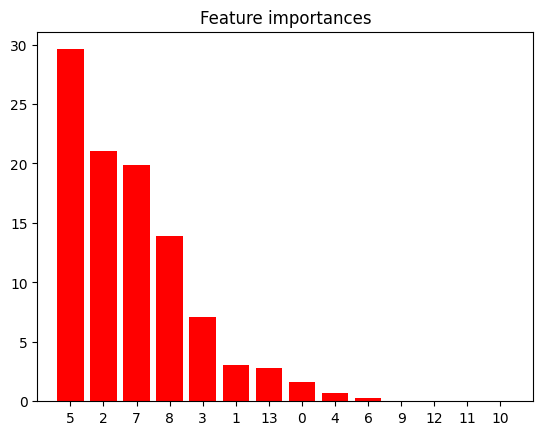

In [16]:
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order


# Print the feature ranking and correlation with the target variable
print("Feature ranking and correlation with the target variable:")
for f in range(X_train.shape[1]):
    feature_index = indices[f]
    feature_name = X_train.columns[feature_index]
    correlation = np.corrcoef(X_train.iloc[:, feature_index], y_train)[0, 1]
    print(f"{f + 1}. Feature {feature_index} ({feature_name}): Importance - {importances[feature_index]}, Correlation - {correlation}")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()